In [17]:
# ============================================================================
# IMPORTS AND SETUP
# ============================================================================

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from PIL import Image
from model import UNet, DoubleConv
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from tqdm import tqdm

# Set random seeds
from utils import (
    DiceBCELoss,
    train_epoch,
    validate_epoch,
    EarlyStopping
)

# Set random seeds
SEED = 1337
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

torch.backends.cudnn.benchmark = True


Using device: cuda


In [16]:
# ============================================================================\n
# CONFIGURATION (Updated for Task 2)
# ============================================================================\n
train_file = 'train.txt'
val_file = 'val.txt'

class Config:
    # Dataset paths
    DATASET_PATH = "data\\kvasir-seg"
    IMAGE_DIR = "images"
    MASK_DIR = "masks"
    
    # Experiment parameters
    # RESOLUTIONS = [512, 256, 128, 64] # <-- Removed/Commented out (Task 1 only)
    TARGET_SIZE = 256
    
    # Training parameters
    BATCH_SIZE = 8
    NUM_EPOCHS = 25
    LEARNING_RATE = 1e-4
    
    # Early stopping
    EARLY_STOPPING_PATIENCE = 5 
    # LR Scheduler
    SCHEDULER_PATIENCE = 3 
    SCHEDULER_FACTOR = 0.1 
    
    # Model parameters
    IN_CHANNELS = 3
    OUT_CHANNELS = 1
    FEATURES = [64, 128, 256, 512]
    
config = Config()

 

In [15]:
class KvasirDataset(Dataset):
    def __init__(self, image_paths, mask_paths, target_size=256, augmentation_type=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        
        # Base transforms (always applied)
        base_transforms = [
            A.Resize(height=target_size, width=target_size, interpolation=cv2.INTER_LINEAR),
        ]
        
        # Add augmentation based on type
        if augmentation_type == 'hflip':
            aug_transforms = [A.HorizontalFlip(p=0.5)]
        elif augmentation_type == 'vflip':
            aug_transforms = [A.VerticalFlip(p=0.5)]
        elif augmentation_type == 'rotate':
            aug_transforms = [A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, 
                                      border_mode=cv2.BORDER_REFLECT_101, p=0.7)]
        elif augmentation_type == 'colorjitter':
            aug_transforms = [A.ColorJitter(brightness=0.2, contrast=0.2, 
                                           saturation=0.2, hue=0.1, p=0.7)]
        elif augmentation_type == 'all':
            aug_transforms = [
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, 
                        border_mode=cv2.BORDER_REFLECT101, p=0.7),
                A.OneOf([
                    A.GaussianBlur(blur_limit=(3, 5), p=0.5),
                    A.ColorJitter(brightness=0.2, contrast=0.2, 
                             saturation=0.2, hue=0.1, p=0.7)
                ],p=0.07)
            ]
        else:
            aug_transforms = []
        
        # Final transforms (always applied)
        final_transforms = [
            A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),
            ToTensorV2()
        ]
        
        # Combine all transforms
        self.transform = A.Compose(base_transforms + aug_transforms + final_transforms)

    def __len__(self):  # <-- MAKE SURE YOU HAVE THIS!
        return len(self.image_paths)
    
    def __getitem__(self, idx):  # <-- AND THIS!
        # Load image and mask with cv2
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
        
        # Binarize mask (0 or 1)
        mask = (mask > 128).astype(np.uint8)
        
        # Apply transforms
        augmented = self.transform(image=image, mask=mask)
        
        image_tensor = augmented['image']
        mask_tensor = augmented['mask']
        
        # Add channel dimension to mask (H, W) -> (1, H, W)
        mask_tensor = mask_tensor.unsqueeze(0).float()
        
        return image_tensor, mask_tensor

# Load dataset paths

In [18]:
# Check files exist
if not os.path.exists('train.txt') or not os.path.exists('val.txt'):
    raise FileNotFoundError('train.txt or val.txt missing!')

# Get all image and mask paths
base_path = Path(config.DATASET_PATH)
image_paths = sorted(list((base_path / config.IMAGE_DIR).glob('*.jpg')))
mask_paths = sorted(list((base_path / config.MASK_DIR).glob('*.jpg')))

if len(image_paths) != len(mask_paths):
    raise ValueError("Mismatch between images and masks!")

print(f"Found {len(image_paths)} images")

# Read train/val split
with open('train.txt', 'r') as f:
    train_stems = {line.strip() for line in f}
with open('val.txt', 'r') as f:
    val_stems = {line.strip() for line in f}

# Split dataset
train_images = [p for p in image_paths if p.stem in train_stems]
train_masks = [p for p in mask_paths if p.stem in train_stems]
val_images = [p for p in image_paths if p.stem in val_stems]
val_masks = [p for p in mask_paths if p.stem in val_stems]

# Print split info
print(f"Training:   {len(train_images)} images ({len(train_images)/(len(train_images)+len(val_images))*100:.1f}%)")
print(f"Validation: {len(val_images)} images ({len(val_images)/(len(train_images)+len(val_images))*100:.1f}%)")



Found 1000 images
Training:   700 images (70.0%)
Validation: 300 images (30.0%)


# MAIN TRAINING LOOP (WITH LR SCHEDULING + EARLY STOPPING)

In [19]:
# ============================================================================
# AUTOMATED EXPERIMENT LOOP - RUNS ALL AUGMENTATIONS
# ============================================================================

# Define all experiments to run
experiments = [None, 'hflip', 'vflip', 'rotate', 'colorjitter']
experiment_results = {}

for AUGMENTATION_TYPE in experiments:
    
    # Determine save name
    aug_name = AUGMENTATION_TYPE if AUGMENTATION_TYPE else 'baseline'
    
    print("=" * 50)
    print(f"STARTING EXPERIMENT FOR AUGMENTATION: {aug_name.upper()}")
    print("=" * 50)
    
    # Re-create datasets for this experiment
    train_dataset = KvasirDataset(
        train_images, 
        train_masks, 
        target_size=config.TARGET_SIZE,
        augmentation_type=AUGMENTATION_TYPE
    )
    
    val_dataset = KvasirDataset(
        val_images, 
        val_masks, 
        target_size=config.TARGET_SIZE,
        augmentation_type=None
    )
    
    # Re-create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=True,
        num_workers=0,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )
    
    # Initialize FRESH model for this experiment
    model = UNet(in_channels=config.IN_CHANNELS, 
                 out_channels=config.OUT_CHANNELS).to(device)
    
    # Loss function
    criterion = DiceBCELoss(weight_dice=0.5, weight_bce=0.5)
    
    # Optimizer
    optimizer = optim.AdamW(model.parameters(), lr=config.LEARNING_RATE, weight_decay=1e-5)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='max',
        factor=config.SCHEDULER_FACTOR,
        patience=config.SCHEDULER_PATIENCE,
        verbose=False  # Don't print LR changes
    )
    
    # Training history
    history = {
        'train_loss': [],
        'train_dice': [],
        'train_iou': [],
        'val_loss': [],
        'val_dice': [],
        'val_iou': [],
        'lr': []
    }
    
    # Early stopping
    best_dice = 0
    best_val_loss = float('inf')
    patience_counter = 0
    
    # Training loop for this experiment
    for epoch in range(config.NUM_EPOCHS):
        
        # Training phase
        train_loss, train_dice, train_iou = train_epoch(
            model, train_loader, criterion, optimizer, device
        )
        
        # Validation phase
        val_loss, val_dice, val_iou = validate_epoch(
            model, val_loader, criterion, device
        )
        
        # Update learning rate
        scheduler.step(val_dice)
        current_lr = optimizer.param_groups[0]['lr']
        
        # Save history
        history['train_loss'].append(train_loss)
        history['train_dice'].append(train_dice)
        history['train_iou'].append(train_iou)
        history['val_loss'].append(val_loss)
        history['val_dice'].append(val_dice)
        history['val_iou'].append(val_iou)
        history['lr'].append(current_lr)
        
        # Print single line format
        print(f"Epoch {epoch+1}/{config.NUM_EPOCHS}.. "
              f"Train Loss: {train_loss:.4f}.. "
              f"Val Loss: {val_loss:.4f}.. "
              f"Val Dice: {val_dice:.4f}.. "
              f"Val IoU: {val_iou:.4f}")
        
        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_dice = val_dice
            best_iou = val_iou
            patience_counter = 0
            print(f"Validation loss decreased ({val_dice:.4f}). Saving model...")
        else:
            patience_counter += 1
            print(f"EarlyStopping counter: {patience_counter} out of {config.EARLY_STOPPING_PATIENCE}")
        
        # Check early stopping
        if patience_counter >= config.EARLY_STOPPING_PATIENCE:
            print(f"Early stopping triggered!")
            break
        
        experiment_results[aug_name] = {
            'val_loss': float(best_val_loss),
            'dice': float(best_dice),
            'iou': float(best_iou)
        }

STARTING EXPERIMENT FOR AUGMENTATION: BASELINE
Epoch 1/25.. Train Loss: 0.5368.. Val Loss: 0.4660.. Val Dice: 0.5863.. Val IoU: 0.4190
Validation loss decreased (0.5863). Saving model...
Epoch 2/25.. Train Loss: 0.4561.. Val Loss: 0.4450.. Val Dice: 0.5937.. Val IoU: 0.4263
Validation loss decreased (0.5937). Saving model...
Epoch 3/25.. Train Loss: 0.4149.. Val Loss: 0.4020.. Val Dice: 0.6301.. Val IoU: 0.4648
Validation loss decreased (0.6301). Saving model...
Epoch 4/25.. Train Loss: 0.3768.. Val Loss: 0.4355.. Val Dice: 0.5378.. Val IoU: 0.3777
EarlyStopping counter: 1 out of 5
Epoch 5/25.. Train Loss: 0.3532.. Val Loss: 0.3550.. Val Dice: 0.6657.. Val IoU: 0.5076
Validation loss decreased (0.6657). Saving model...
Epoch 6/25.. Train Loss: 0.3258.. Val Loss: 0.3315.. Val Dice: 0.6857.. Val IoU: 0.5274
Validation loss decreased (0.6857). Saving model...
Epoch 7/25.. Train Loss: 0.3051.. Val Loss: 0.3043.. Val Dice: 0.7169.. Val IoU: 0.5706
Validation loss decreased (0.7169). Saving 


--- Final Augmentation Experiment Results ---
              val_loss      dice       iou
Augmentation                              
baseline      0.226916  0.791715  0.664871
colorjitter   0.245095  0.774458  0.638342
hflip         0.224431  0.801784  0.677893
rotate        0.223553  0.794000  0.668202
vflip         0.206446  0.807460  0.686331


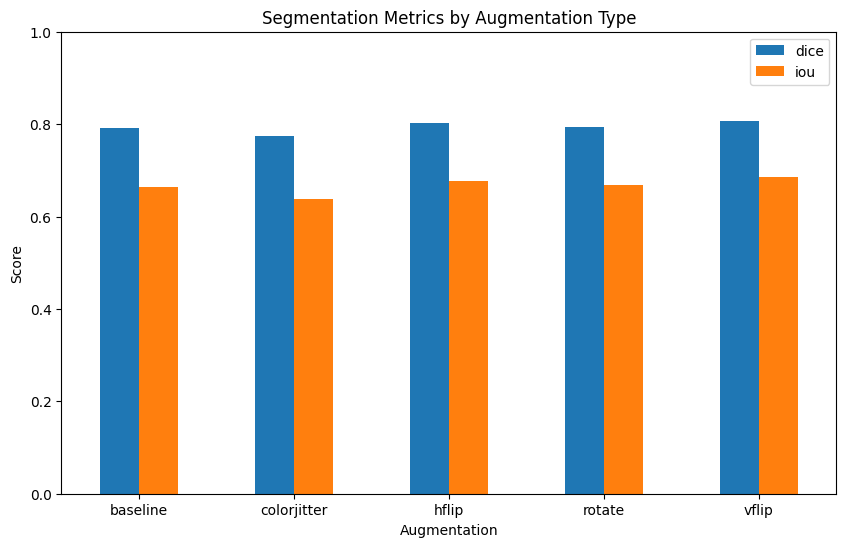

In [20]:
# Convert dictionary to DataFrame
results_df = pd.DataFrame.from_dict(experiment_results, orient='index')
results_df.index.name = 'Augmentation'
results_df = results_df.sort_index()  # sort alphabetically (optional)

print("\n--- Final Augmentation Experiment Results ---")
print(results_df)

# Optional: Plot the results
results_df.plot(kind='bar', y=['dice', 'iou'],
                title='Segmentation Metrics by Augmentation Type',
                figsize=(10, 6))
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.show()